In [21]:
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.model_selection import train_test_split
from sklearn.metrics import silhouette_score
from sklearn import metrics
from sklearn.ensemble import IsolationForest
import plotly.graph_objects as go
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from collections import defaultdict
import numpy as np
from sklearn.cluster import KMeans

In [24]:
# Charger le jeu de données 20newsgroups
data = fetch_20newsgroups(subset='all', shuffle=True, random_state=42)

# Diviser le jeu de données en ensembles d'entraînement et de test
X_train, X_test = train_test_split(data.data, test_size=0.2, random_state=42)

# Créer une représentation vectorielle des documents
vectorizer = CountVectorizer(max_features=1000, max_df=0.5, min_df=2, stop_words='english')
X_train_vectorized = vectorizer.fit_transform(X_train)
X_test_vectorized = vectorizer.transform(X_test)

# Créer le modèle LDA
lda = LatentDirichletAllocation(n_components=10, random_state=42)
lda.fit(X_train_vectorized)

# Attribuer les documents de l'ensemble d'entraînement à des sujets
train_topic_assignments = lda.transform(X_train_vectorized)

# Attribuer les documents de l'ensemble de test à des sujets
test_topic_assignments = lda.transform(X_test_vectorized)

# Calculer le score de silhouette pour l'ensemble de test
silhouette_avg = silhouette_score(X_test_vectorized, test_topic_assignments.argmax(axis=1))
print(f"Silhouette Score: {silhouette_avg}")

# Utiliser le modèle IsolationForest pour évaluer la pertinence de l'entraînement sur les données de test
isolation_forest = IsolationForest(random_state=42)
isolation_forest.fit(X_train_vectorized)
outliers = isolation_forest.predict(X_test_vectorized)
outlier_percentage = list(outliers).count(-1) / len(outliers)
print(f"Outlier Percentage: {outlier_percentage}")

topic_word_distributions = lda.components_
topics = []
for topic_idx, topic_words in enumerate(topic_word_distributions):
    top_words = [list(vectorizer.vocabulary_.keys())[i] for i in topic_words.argsort()[:-6:-1]]
    topics.append(', '.join(top_words))

Silhouette Score: -0.07864310232806208
Outlier Percentage: 0.009549071618037135


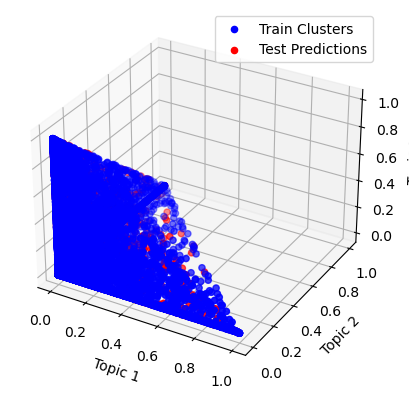

In [25]:
# Visualiser les clusters d'entraînement et les prédictions sur les données de test en 3D Statique
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Coordonnées des sujets d'entraînement
train_x = train_topic_assignments[:, 0]
train_y = train_topic_assignments[:, 1]
train_z = train_topic_assignments[:, 2]
ax.scatter(train_x, train_y, train_z, c='blue', label='Train Clusters')

# Coordonnées des sujets de test
test_x = test_topic_assignments[:, 0]
test_y = test_topic_assignments[:, 1]
test_z = test_topic_assignments[:, 2]
ax.scatter(test_x, test_y, test_z, c='red', label='Test Predictions')

ax.set_xlabel('Topic 1')
ax.set_ylabel('Topic 2')
ax.set_zlabel('Topic 3')
ax.legend()

plt.show()

In [38]:
# Visualiser les clusters d'entraînement et les prédictions sur les données de test en 3D
# Créer les coordonnées x, y et z pour chaque point de données
x_train = train_topic_assignments[:, 0]
y_train = train_topic_assignments[:, 1]
z_train = train_topic_assignments[:, 2]

x_test = test_topic_assignments[:, 0]
y_test = test_topic_assignments[:, 1]
z_test = test_topic_assignments[:, 2]

# Afficher les clusters trouvés lors de l'entraînement en 3D
cluster_labels = KMeans(n_clusters=10, random_state=0).fit_predict(train_topic_assignments)

fig = go.Figure(data=[
    go.Scatter3d(x=x_train, y=y_train, z=z_train, mode='markers', marker=dict(size=2, opacity=0.7, color=cluster_labels),name='Train'),
    go.Scatter3d(x=x_test, y=y_test, z=z_test, mode='markers', marker=dict(size=2, opacity=0.7, color=cluster_labels),name='Test')
])
fig.update_layout(scene=dict(xaxis_title='X', yaxis_title='Y', zaxis_title='Z'))
# fig.(*cluster_labels.item(), title='Clusters')
fig.show()


c:\Users\Elion\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

